In [1]:
import load_data, rotplot
import math
import matplotlib.pyplot as plt
import autograd.numpy as np
import transforms3d
import optimization
from main import generate_and_save_optimization
import plot_imu_data

In [4]:
dataset_list="23456789"
for dataset in dataset_list:
    generate_and_save_optimization(dataset=dataset,epochs=10,alpha=.003)

Data import took: 0.008555173873901367 sec.

Loss at iteration 1: 46041.37
Loss at iteration 2: 44319.36
Loss at iteration 3: 43201.87
Loss at iteration 4: 42439.27
Loss at iteration 5: 41898.70
Loss at iteration 6: 41504.46
Loss at iteration 7: 41210.56
Loss at iteration 8: 40987.64
Loss at iteration 9: 40816.09
Loss at iteration 10: 40682.47
Data import took: 0.00419306755065918 sec.

Loss at iteration 1: 33033.76
Loss at iteration 2: 32063.07
Loss at iteration 3: 31226.78
Loss at iteration 4: 30527.04
Loss at iteration 5: 29953.21
Loss at iteration 6: 29488.28
Loss at iteration 7: 29113.51
Loss at iteration 8: 28811.26
Loss at iteration 9: 28566.50
Loss at iteration 10: 28367.07
Data import took: 0.004314899444580078 sec.

Loss at iteration 1: 32403.46
Loss at iteration 2: 30992.01
Loss at iteration 3: 29962.55
Loss at iteration 4: 29187.25
Loss at iteration 5: 28587.73
Loss at iteration 6: 28114.04
Loss at iteration 7: 27733.08
Loss at iteration 8: 27422.17
Loss at iteration 9: 271

In [5]:
dataset_1_loss = [54027.50,52294.74,51164.48,50389.90,49838.89,49435.61,49133.80,48903.81,48725.91,48586.50]
dataset_2_loss = [46041.37,44319.36,43201.87,42439.27,41898.70,41504.46,41210.56,40987.64,40816.09,40682.47]
dataset_3_loss = [33033.76, 32063.07, 31226.78, 30527.04, 29953.21, 29488.28, 29113.51, 28811.26, 28566.50,28367.07]
dataset_4_loss = [32403.46,30992.01,29962.55, 29187.25, 28587.73, 28114.04, 27733.08, 27422.17, 27165.29,26950.79]
dataset_5_loss = [66406.50,60668.86, 54833.80, 49728.56, 45588.97, 42276.76, 39595.05, 37392.57, 35560.21, 34019.75]
dataset_6_loss = [38345.01, 36102.42, 34411.56, 33113.83, 32100.86, 31297.31, 30650.96, 30125.33, 29694.27, 29338.29]
dataset_7_loss = [42766.15,40110.75,38125.53,36615.96,35453.08,34546.01,33829.37,33256.05,32791.69,32411.12]
dataset_8_loss = [32403.46, 30992.01, 29962.55, 29187.25, 28587.73, 28114.04, 27733.08, 27422.17, 27165.29,26950.79]
dataset_9_loss = [37342.43,34777.38, 32606.05, 30823.34, 29386.06, 28237.43, 27321.92, 26591.27, 26005.99, 25534.89]

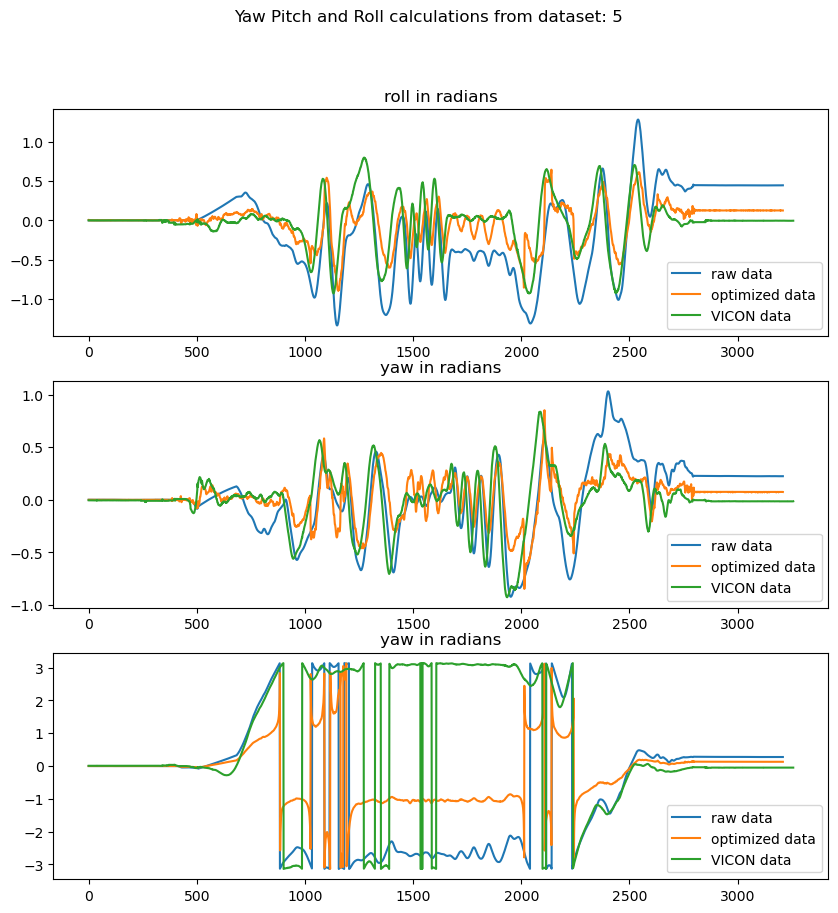

In [4]:
plot_imu_data.plot(dataset="5",path="/Users/justin/Documents/Homework/ECE 276A/ECE 276A Project 1/ECE276A_PR1/numpy files")

In [2]:
dataset="3"
[camera,imu,Vicd] = load_data.load(fname="../../trainset",dataset=dataset)

Data import took: 0.0035889148712158203 sec.



In [3]:
rots = []
for i in range(Vicd['rots'].shape[2]):
    rots.append(list(transforms3d.euler.mat2euler(Vicd['rots'][:,:,i])))

rots = np.array(rots)

In [4]:
sc_ft_ang=3300/1023*(math.pi)/180/3.33
sc_ft_acc=3300/1023/300

Wz = imu['vals'][3]
Wx = imu['vals'][4]
Wy = imu['vals'][5]
Ang_Veloc = np.array([Wx*sc_ft_ang,Wy*sc_ft_ang,Wz*sc_ft_ang])

Ax = imu['vals'][0].astype(np.float32)*sc_ft_acc
Ay = imu['vals'][1].astype(np.float32)*sc_ft_acc
Az = imu['vals'][2].astype(np.float32)*sc_ft_acc
Ang_Acc = np.array([-Ax,-Ay,Az],dtype=np.float32)

time = imu['ts'][0]

tau = np.zeros((len(time)-1,1))
for i,t in enumerate(time,start=0):
    if i == 0:
        continue
    else:
        tau[i-1] = t - time[i-1]
bias_ang_x=np.average(Ang_Veloc[0,0:100])
bias_ang_y=np.average(Ang_Veloc[1,0:100])
bias_ang_z=np.average(Ang_Veloc[2,0:100])
bias_acc_x=np.average(Ang_Acc[0,0:100])
bias_acc_y=np.average(Ang_Acc[1,0:100])
bias_acc_z=np.average(Ang_Acc[2,0:100])
Ang_Veloc[0] = Ang_Veloc[0] - bias_ang_x
Ang_Veloc[1] = Ang_Veloc[1] - bias_ang_y
Ang_Veloc[2] = Ang_Veloc[2] - bias_ang_z
Ang_Acc[0] = Ang_Acc[0] - bias_acc_x
Ang_Acc[1] = Ang_Acc[1] - bias_acc_y
Ang_Acc[2] = Ang_Acc[2] - bias_acc_z + 1

In [5]:
import quarternions

quarternions_T = quarternions.predict_next_quarternion(tau,Ang_Veloc)

In [6]:
quarts = np.array(quarternions_T)

In [7]:
print(quarts.shape)
print(tau[:,0].shape)
print(Ang_Veloc.T.shape)
print(Ang_Acc.T.shape)

(3404, 4)
(3403,)
(3404, 3)
(3404, 3)


In [8]:
optimized_qts = optimization.optimize(quarts,Ang_Acc.T,tau[:,0],Ang_Veloc.T,epochs=10,alpha=.003)

Loss at iteration 1: 33033.76
Loss at iteration 2: 32063.07
Loss at iteration 3: 31226.78
Loss at iteration 4: 30527.04
Loss at iteration 5: 29953.21
Loss at iteration 6: 29488.28
Loss at iteration 7: 29113.51
Loss at iteration 8: 28811.26
Loss at iteration 9: 28566.50
Loss at iteration 10: 28367.07


In [9]:
print(optimized_qts)

[[ 9.99998764e-01  1.53742394e-03 -3.28408225e-04 -3.24036764e-07]
 [ 9.99999897e-01 -3.23456629e-04 -3.18448051e-04  2.00499418e-05]
 [ 9.99999873e-01 -3.78480618e-04 -3.33346305e-04 -1.35434232e-05]
 ...
 [-9.93572822e-01  7.80998975e-03 -7.94199279e-03 -1.12645357e-01]
 [-9.93577357e-01  7.79747240e-03 -7.95794262e-03 -1.12605085e-01]
 [-9.93603106e-01  7.80744714e-03 -7.95076474e-03 -1.12377475e-01]]


In [10]:
np.save("../numpy files/data_set_" + dataset + "_optimized_quarternions",optimized_qts)
np.save("../numpy files/data_set_" + dataset + "_raw_quarternions",quarternions_T)
np.save("../numpy files/data_set_" + dataset + "_vicon_data",rots)

In [11]:
euler_angles = list(map(lambda quart: transforms3d.euler.quat2euler(quart),quarternions_T))
roll = list(map(lambda angles: angles[0],euler_angles))
pitch = list(map(lambda angles: angles[1],euler_angles))
yaw = list(map(lambda angles: angles[2],euler_angles))

In [12]:
opt_euler_angles = list(map(lambda quart: transforms3d.euler.quat2euler(quart),optimized_qts))
opt_roll = list(map(lambda angles: angles[0],opt_euler_angles))
opt_pitch = list(map(lambda angles: angles[1],opt_euler_angles))
opt_yaw = list(map(lambda angles: angles[2],opt_euler_angles))

Text(0.5, 0.98, 'Yaw Pitch and Roll calculations from dataset: 3')

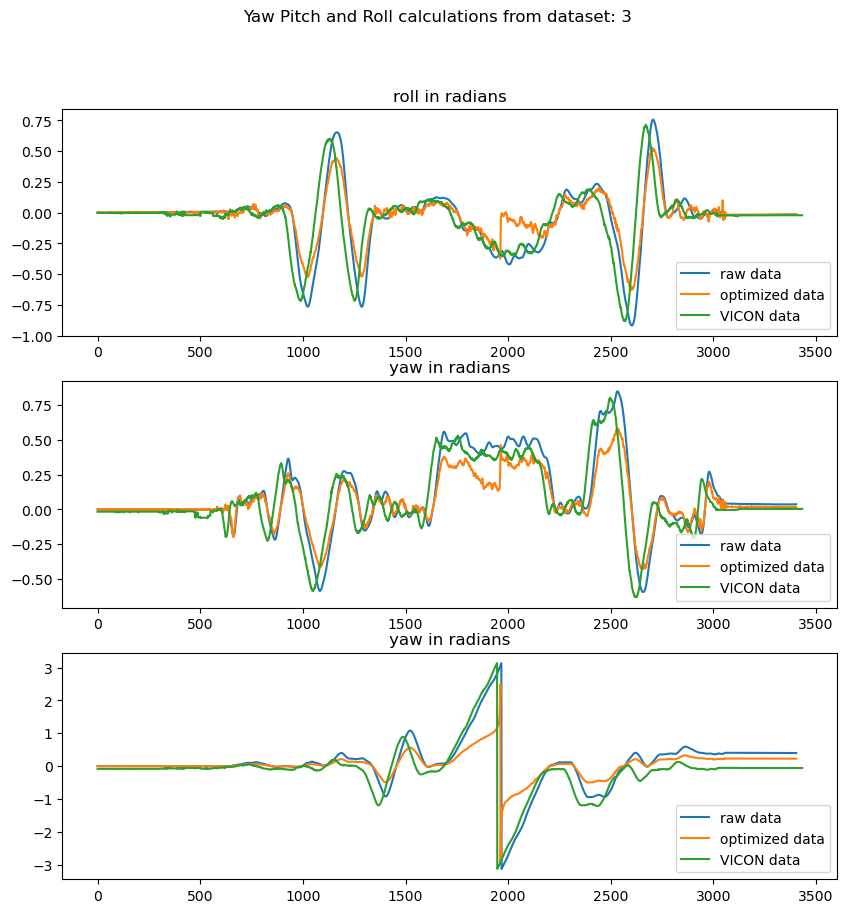

In [13]:
fig, ax = plt.subplots(3,1,figsize=(10,10))

ax[0].plot(roll)
ax[0].set_title("roll in radians")
ax[0].plot(opt_roll)
ax[0].plot(rots[:,0])
ax[1].plot(pitch)
ax[1].set_title("yaw in radians")
ax[1].plot(opt_pitch)
ax[1].plot(rots[:,1])
ax[2].plot(yaw)
ax[2].plot(opt_yaw)
ax[2].set_title("yaw in radians")
ax[2].plot(rots[:,2])
ax[0].legend(['raw data','optimized data','VICON data'],loc='lower right')
ax[1].legend(['raw data','optimized data','VICON data'],loc='lower right')
ax[2].legend(['raw data','optimized data','VICON data'],loc='lower right')
fig.suptitle('Yaw Pitch and Roll calculations from dataset: ' + dataset)

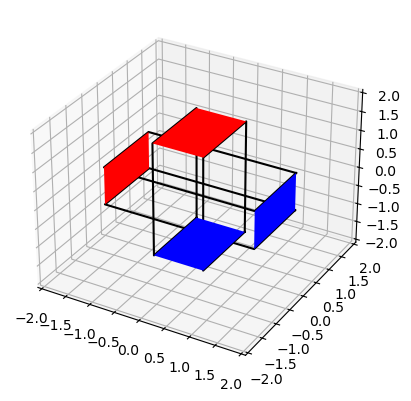

In [14]:
rotplot.example()